# Neural Network using Pytorch library

In [22]:
import os
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np


## Check if hardware accelerators such as GPU or MPS are available, if not CPU

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [3]:
torch.zeros(1).cuda()

AssertionError: Torch not compiled with CUDA enabled

In [4]:
# For CPU, BORRAR DESPRES SI VOLS
torch.zeros(1).to(device)

tensor([0.])

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('clean.csv')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['price']).values, df['price'].values, test_size=0.2, random_state=42)


In [6]:
from torch.utils.data import Dataset, DataLoader
import torch

class FlightDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32, device=device)
        self.y = torch.tensor(y, dtype=torch.float32, device=device).view(-1, 1)  # Ensure target is 2D for regression

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create PyTorch datasets and data loaders
train_dataset = FlightDataset(X_train, y_train)
test_dataset = FlightDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
import torch.nn.functional as F
class PricePredictor(nn.Module):
    def __init__(self, input_size):
        super(PricePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # Single output for regression

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [8]:
input_size = X_train.shape[1]  # Number of features

model = PricePredictor(input_size).to(device)
print(model)

criterion = nn.MSELoss()  # Regression loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

PricePredictor(
  (fc1): Linear(in_features=27, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [9]:
epochs = 50

for epoch in range(epochs):
    model.train()  # Training mode
    total_loss = 0

    for inputs, targets in train_loader:
        # Forward pass
        predictions = model(inputs)
        loss = criterion(predictions, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/50], Loss: 635219556.2885
Epoch [2/50], Loss: 248676307.6937
Epoch [3/50], Loss: 173260052.1247
Epoch [4/50], Loss: 139122302.2422
Epoch [5/50], Loss: 111397426.1710
Epoch [6/50], Loss: 98282488.9866
Epoch [7/50], Loss: 92844732.6857
Epoch [8/50], Loss: 89607672.3028
Epoch [9/50], Loss: 86782004.1594
Epoch [10/50], Loss: 84555770.3695
Epoch [11/50], Loss: 82200783.4826
Epoch [12/50], Loss: 80257819.6821
Epoch [13/50], Loss: 78444098.3330
Epoch [14/50], Loss: 76950454.5200
Epoch [15/50], Loss: 75369031.3580
Epoch [16/50], Loss: 74118302.8255
Epoch [17/50], Loss: 72883539.3713
Epoch [18/50], Loss: 72006083.6215
Epoch [19/50], Loss: 71353158.5129
Epoch [20/50], Loss: 70847287.4907
Epoch [21/50], Loss: 70088258.3874
Epoch [22/50], Loss: 69883837.7418
Epoch [23/50], Loss: 69380393.5076
Epoch [24/50], Loss: 69242312.9457
Epoch [25/50], Loss: 69246960.5476
Epoch [26/50], Loss: 68949060.4844
Epoch [27/50], Loss: 68904582.4230
Epoch [28/50], Loss: 68831900.8629
Epoch [29/50], Loss: 688

In [32]:
model.eval()  # Evaluation mode
test_loss = 0

with torch.no_grad():  # Disable gradient calculation
    for inputs, targets in test_loader:
        predictions = model(inputs)
        loss = criterion(predictions, targets)
        test_loss += loss.item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}")


Test Loss: 68625979.0641


In [37]:
# Borrar nomes per veure que fallava
print(model)
print(new_data.shape)
print(df.columns)

PricePredictor(
  (fc1): Linear(in_features=27, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)
torch.Size([1, 28])
Index(['to_Bangalore', 'to_Chennai', 'to_Delhi', 'to_Hyderabad', 'to_Kolkata',
       'to_Mumbai', 'arr_time_Afternoon', 'arr_time_Evening',
       'arr_time_Morning', 'arr_time_Night', 'from_Bangalore', 'from_Chennai',
       'from_Delhi', 'from_Hyderabad', 'from_Kolkata', 'from_Mumbai',
       'dep_time_Afternoon', 'dep_time_Evening', 'dep_time_Morning',
       'dep_time_Night', 'airline_Air India', 'airline_Vistara', 'time_taken',
       'stop', 'price', 'distance', 'dia', 'mes'],
      dtype='object')


In [50]:
# Only predict for to_Hyderabad crec
df_new = df.drop(columns=['price'])
new_data = torch.tensor(df_new.iloc[3].values, dtype=torch.float32, device=device)

predicted_price = model(new_data)
print(f"Predicció del preu: {predicted_price.item():.2f}")

Predicció del preu: 50461.66


In [56]:
# Predict all
df_new = df.drop(columns=['price'])
predicted_prices = []

for _, row in df_new.iterrows():
    new_data = torch.tensor(row.values, dtype=torch.float32, device=device).unsqueeze(0)
    predicted_price = model(new_data)
    predicted_prices.append(predicted_price.item())


In [57]:
for real, pred in zip(df['price'], predicted_prices):
    print(f"Real: {real:.2f} \t Predicted: {pred:.2f}")


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Real: 50385.00 	 Predicted: 49275.39
Real: 51928.00 	 Predicted: 69782.48
Real: 52139.00 	 Predicted: 50610.36
Real: 58795.00 	 Predicted: 49265.66
Real: 60260.00 	 Predicted: 60143.71
Real: 60260.00 	 Predicted: 60025.47
Real: 60260.00 	 Predicted: 59896.47
Real: 60260.00 	 Predicted: 58324.80
Real: 60260.00 	 Predicted: 59778.22
Real: 60260.00 	 Predicted: 60477.44
Real: 60260.00 	 Predicted: 60434.44
Real: 60260.00 	 Predicted: 58185.06
Real: 60260.00 	 Predicted: 60230.20
Real: 60260.00 	 Predicted: 60187.20
Real: 60260.00 	 Predicted: 59112.60
Real: 60260.00 	 Predicted: 58994.35
Real: 60260.00 	 Predicted: 57807.96
Real: 60260.00 	 Predicted: 58892.23
Real: 60260.00 	 Predicted: 57668.21
Real: 60260.00 	 Predicted: 57560.72
Real: 60260.00 	 Predicted: 50494.52
Real: 60260.00 	 Predicted: 52408.26
Real: 60260.00 	 Predicted: 52166.39
Real: 60260.00 	 Predicted: 52844.11
Real: 60260.00 	 Predicted: 52602.25
Real: 60260.00 	 Predicted: 50483.92
Real: 60260.00 	 Predicted: 50529.49
R

In [64]:
# Calculate MSE, MAE i MAPE
print(
  'mean_squared_error : ', mean_squared_error(df['price'], predicted_prices))
print(
  ' mean_absolute_error : ', mean_absolute_error(df['price'], predicted_prices))

print(
  'mean_absolute_percentage_error : ', np.mean(np.abs((df['price'] - np.array(predicted_prices)) / df['price'])) * 100)

mean_squared_error :  68239701.28629352
 mean_absolute_error :  6455.663266788044
mean_absolute_percentage_error :  13.126233110981254


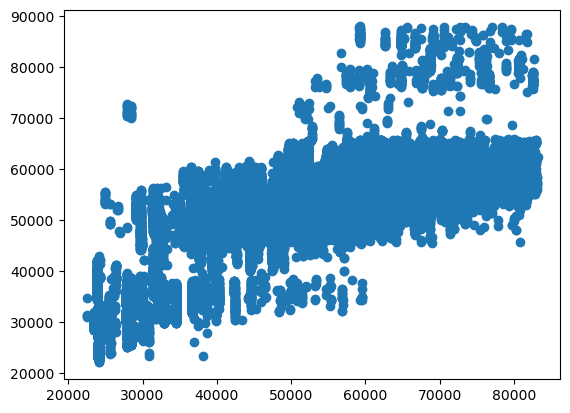

In [65]:
import matplotlib.pyplot as plt

plt.scatter(df['price'], predicted_prices)


In [66]:
# Example: the cheapest flights
df['predicted_price'] = predicted_prices
cheapest_flights = df.sort_values(by='predicted_price').head(5)
print(cheapest_flights)


       to_Bangalore  to_Chennai  to_Delhi  to_Hyderabad  to_Kolkata  \
66627             0           0         1             0           0   
66261             0           0         1             0           0   
66786             0           0         1             0           0   
66738             0           0         1             0           0   
66682             0           0         1             0           0   

       to_Mumbai  arr_time_Afternoon  arr_time_Evening  arr_time_Morning  \
66627          0                   1                 0                 0   
66261          0                   1                 0                 0   
66786          0                   1                 0                 0   
66738          0                   1                 0                 0   
66682          0                   1                 0                 0   

       arr_time_Night  ...  dep_time_Night  airline_Air India  \
66627               0  ...               0         